# Contrôle de TP Apprentissage Automatique 1

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquement de feu, horloge, chant de coq, etc...).

Les fichiers audio sont convertis en spectrogrammes, une représentation temps/fréquence du signal qui peut être vue comme une image.


### Imports



In [1]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [2]:
!pip -q install librosa
import librosa
import librosa.display

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [ ]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [6]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [4]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))
                    
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [7]:
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 18.1 s, sys: 38.4 s, total: 56.5 s
Wall time: 5.93 s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [8]:

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)


Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [47]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[119] = tensor(3) -> crying_baby
• y_train[258] = tensor(8) -> sea_waves
• y_train[308] = tensor(9) -> sneezing
• y_train[13] = tensor(0) -> chainsaw
• y_train[287] = tensor(8) -> sea_waves
• y_train[101] = tensor(3) -> crying_baby
• y_train[366] = tensor(4) -> dog
• y_train[332] = tensor(1) -> clock_tick
• y_train[359] = tensor(3) -> crying_baby
• y_train[279] = tensor(8) -> sea_waves


**Affichage de quelques spectrogrammes**


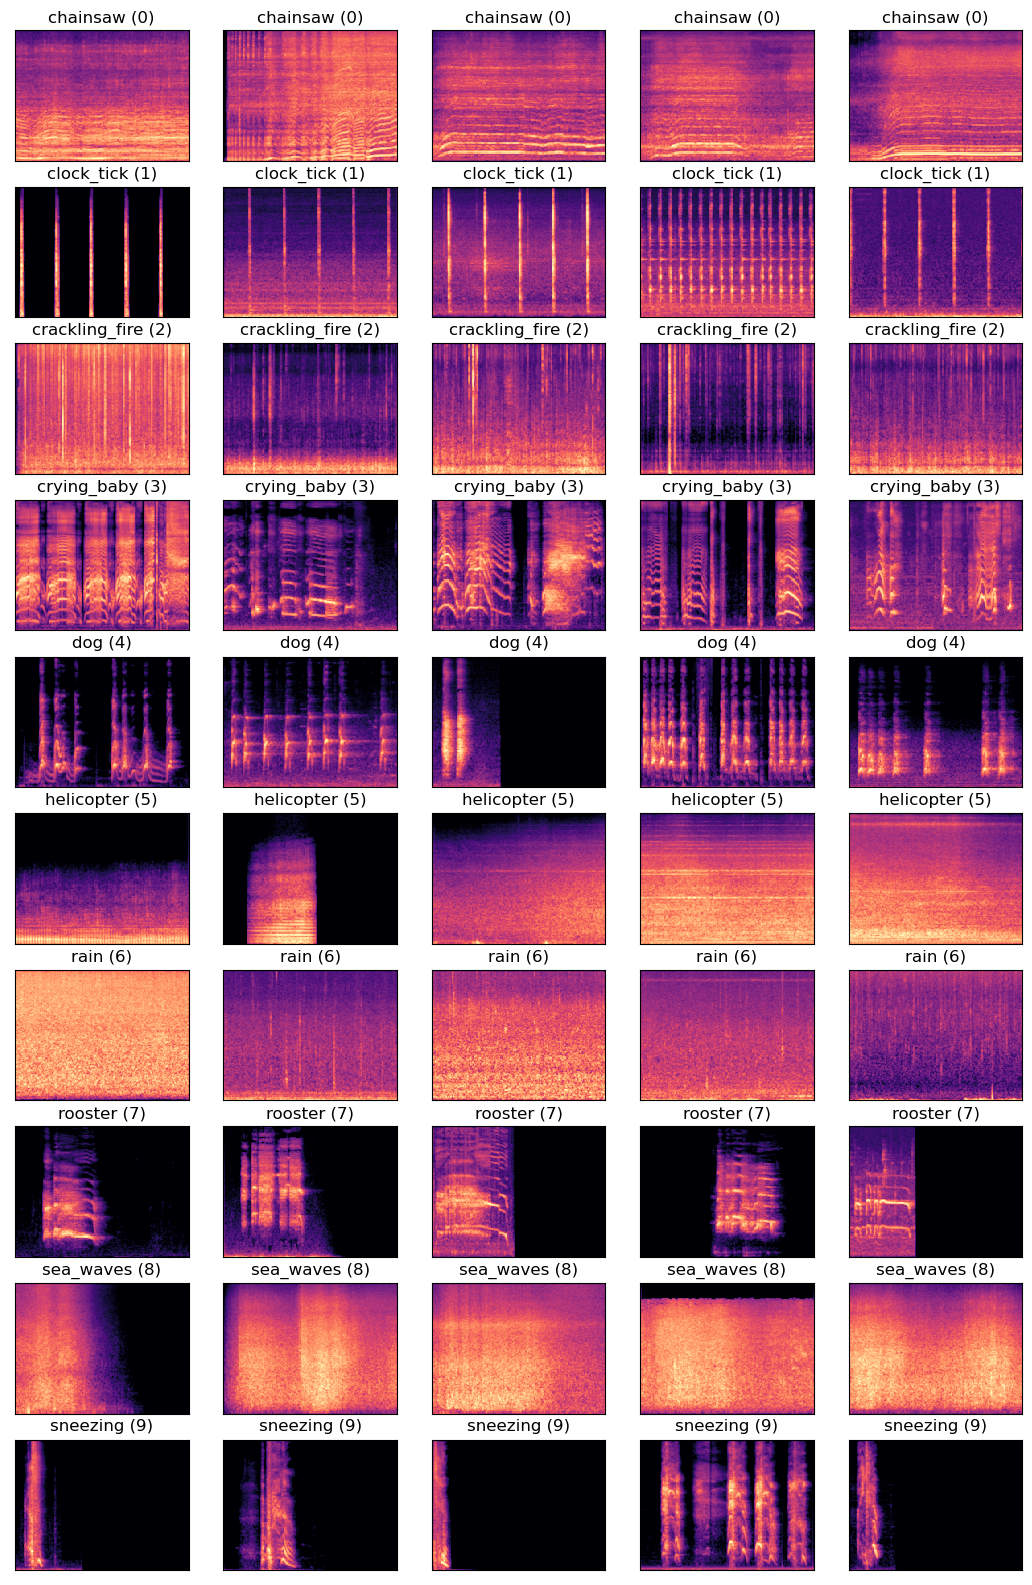

In [10]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

## Augmentation des Audios

In [16]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal.astype(np.float32)


def pitch_scale(signal, sr, num_semitones):
    """Pitch scaling implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=num_semitones)


def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def invert_polarity(signal):
    return signal * -1

In [17]:
# ecouter l'Audio
def play_audio(y, sr):
    return Audio(data=y, rate=sr)

# choose random audio class
label_idx = random.randint(0, len(idx_to_classes) - 1)
label = idx_to_classes[label_idx]

audio_files = [entry.path for entry in os.scandir(os.path.join(train_dir, label)) 
               if entry.name.endswith('.wav') and not entry.name.startswith('.')]
random_audio_file = random.choice(audio_files)

data_number = audio_files.index(random_audio_file)

print("Data number:", data_number)
print("Label:", label, " , class:", label_idx)  

# Load and play the selected audio
signal, sr = librosa.load(random_audio_file)
print("Signal originale: ")
play_audio(signal, sr)

Data number: 15
Label: helicopter  , class: 5
Signal originale: 


In [14]:
print("Audio augmneté: ")
signal_augmented = pitch_scale(signal, sr, 2)
play_audio(signal_augmented, sr)

Audio augmneté: 


#### Apliquer augmentation aléatoire sur les datas de trainig

In [18]:
noise_percentage_factor = 0.05
time_stretch_rate = 0.8
num_semitones = 2
min_gain_factor = 0.9
max_gain_factor = 1.1

def load_dataset_augmentee():
    path = train_dir
    spec = []
    labels = []
    itr = 0
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    
                    # augmente 1 data every 3 itr
                    if itr%3 == 0:
                        # on choisi le type d'augmentation aléatoirement
                        if random.choice([True, False]):
                            y = pitch_scale(y, sr, num_semitones)
                        if random.choice([True, False]):
                            y = random_gain(y, min_gain_factor, max_gain_factor)
                        if random.choice([True, False]):
                            y = invert_polarity(y)
                        if random.choice([True, False]):
                            y = add_white_noise(y, noise_percentage_factor)

                        # convert audio to melspectrogram
                        spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))
                    
                        # add associated label
                        labels.append(idx)
                    itr += 1

    return np.array(spec), np.array(labels)


print("Chargement du corpus d'apprentissage augmenté")
x_train_augmente, y_train_augmente = load_dataset_augmentee()

Chargement du corpus d'apprentissage augmenté


**Ajouter les données augmenté**

In [19]:
x_train = np.concatenate((x_train, x_train_augmente), axis=0)
y_train = np.concatenate((y_train, y_train_augmente), axis=0)


# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')


Taille des données d'apprentissage
	• X_train (images) : (427, 128, 216)
	• y_train (labels) : (427,)
Taille du corpus total
	• train : 427 exemples
	• test : 80 exemples


# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [20]:
nb_classes = 10

# numpy vers tensors
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)

# numpy vers tensors
X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [21]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [29]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie.

In [23]:
# Perceptron multi-couche 
class MLP(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP, self).__init__()
        self.input_size = height * width # 128 x 216
        self.layer1 = nn.Linear(self.input_size, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1, self.input_size) # flatten le spectro
        hidden_output = F.relu(self.layer1(flattened))
        return self.layer2(hidden_output)


Compléter la fonction d'apprentissage

In [49]:
from tqdm import tqdm

def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9, 
          num_epochs=10):
    
    # la loss 
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (imgs, labels) in progress_bar:
            # if imgs.size()[0] < batch_size:
            #     continue
            # print(imgs.size())

            model.train() # met le modèle en mode train
            out = model(imgs) # forward
            loss = criterion(out, labels) # calcul de la loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}')

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # training accuracy 
              val_acc.append(get_accuracy(model, train=False))  # test accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [50]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [51]:
mlp = MLP()
print(mlp)

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

Epoch 1/10 | Loss: 1.8663: 100%|██████████| 14/14 [00:00<00:00, 23.18it/s]
Epoch 2/10 | Loss: 1.7708: 100%|██████████| 14/14 [00:00<00:00, 19.55it/s]
Epoch 3/10 | Loss: 2.1640: 100%|██████████| 14/14 [00:00<00:00, 19.68it/s]
Epoch 4/10 | Loss: 1.8256: 100%|██████████| 14/14 [00:00<00:00, 43.37it/s]
Epoch 5/10 | Loss: 2.1245: 100%|██████████| 14/14 [00:00<00:00, 21.25it/s]
Epoch 6/10 | Loss: 1.5659: 100%|██████████| 14/14 [00:00<00:00, 19.65it/s]
Epoch 7/10 | Loss: 1.8015: 100%|██████████| 14/14 [00:00<00:00, 38.22it/s]
Epoch 8/10 | Loss: 1.2924: 100%|██████████| 14/14 [00:00<00:00, 22.40it/s]
Epoch 9/10 | Loss: 1.3717: 100%|██████████| 14/14 [00:00<00:00, 22.46it/s]
Epoch 10/10 | Loss: 1.8347: 100%|██████████| 14/14 [00:00<00:00, 34.97it/s]


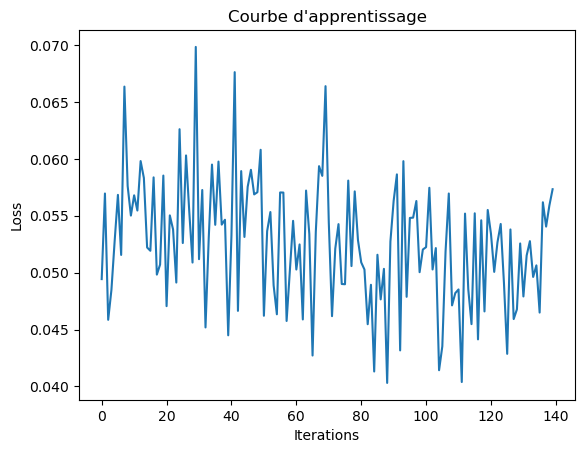

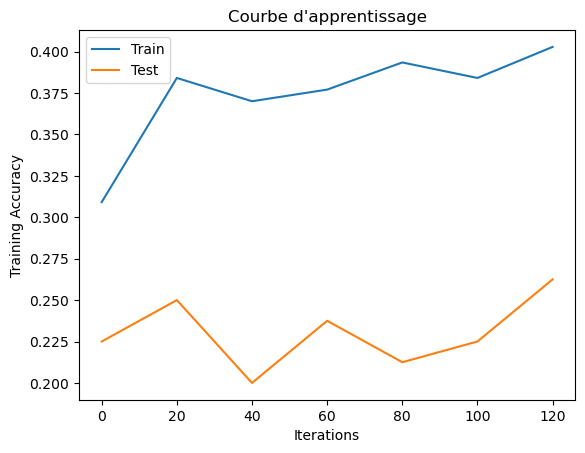

Précision finale Train : 0.4028103044496487
Précision finale Test : 0.2625


In [54]:
train(mlp, num_epochs=10, learning_rate=0.0001, optimizer="adam", batch_size=32)

**MLP Amélioré**

In [59]:
import torch.nn.init as init


class MLPbetter(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLPbetter, self).__init__()
        self.input_size = height * width # 128 x 216
        self.layer1 = nn.Linear(self.input_size, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        # vous pouvez définir d'autres couches dans un deuxième temps
        self.layer3 = nn.Linear(num_hidden, 10)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm1d(num_hidden)
        self.batch_norm2 = nn.BatchNorm1d(num_hidden)

        # Initialize weights using Xavier initialization
        self.initialize_weights()
        

    def forward(self, spectro):
        flattened = spectro.view(-1, self.input_size) # flatten le spectro
        hidden_output = F.relu(self.batch_norm1(self.layer1(flattened)))
        x = F.relu(self.batch_norm2(self.layer2(hidden_output)))
        return self.layer3(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)

In [60]:
mlpBetter = MLPbetter()
print(mlpBetter)

MLPbetter(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 1.9116: 100%|██████████| 14/14 [00:00<00:00, 21.02it/s]
Epoch 2/10 | Loss: 1.4076: 100%|██████████| 14/14 [00:00<00:00, 22.48it/s]
Epoch 3/10 | Loss: 1.0803: 100%|██████████| 14/14 [00:00<00:00, 22.65it/s]
Epoch 4/10 | Loss: 0.9922: 100%|██████████| 14/14 [00:00<00:00, 48.33it/s]
Epoch 5/10 | Loss: 1.3056: 100%|██████████| 14/14 [00:00<00:00, 20.61it/s]
Epoch 6/10 | Loss: 1.5670: 100%|██████████| 14/14 [00:00<00:00, 22.17it/s]
Epoch 7/10 | Loss: 0.8709: 100%|██████████| 14/14 [00:00<00:00, 52.75it/s]
Epoch 8/10 | Loss: 0.8124: 100%|██████████| 14/14 [00:00<00:00, 22.04it/s]
Epoch 9/10 | Loss: 1.0552: 100%|██████████| 14/14 [00:00<00:00, 22.18it/s]
Epoch 10/10 | Loss: 0.8125: 100%|██████████| 14/14 [00:00<00:00, 45.70it/s]


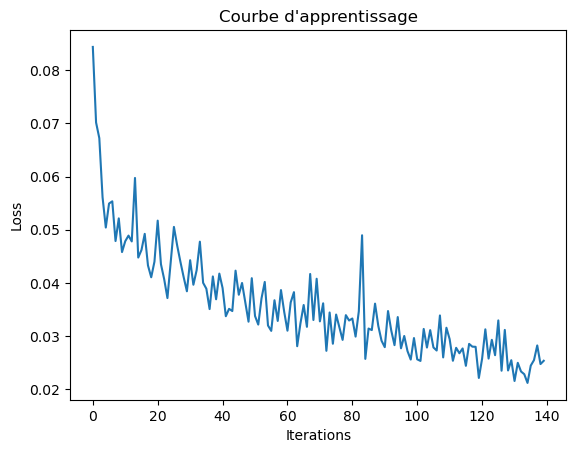

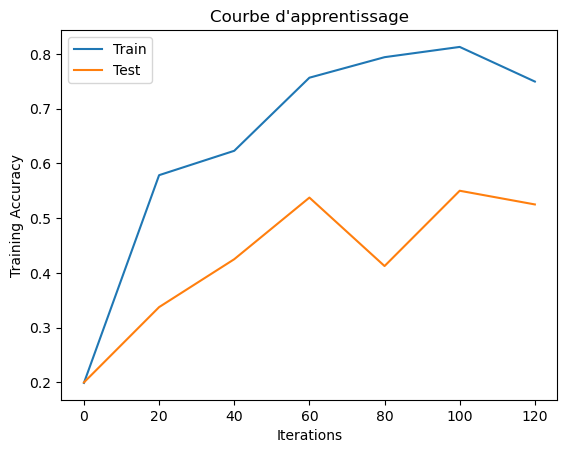

Précision finale Train : 0.7494145199063232
Précision finale Test : 0.525


In [61]:
train(mlpBetter, num_epochs=10, learning_rate=0.0001, optimizer="adam", batch_size=32)

On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN. 

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement. 

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes. 

Une ReLU sera appliquée après chaque couche de convolution et après fc1. 

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32*14*25 , 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        # output_height = (input_height - kernel_height + 2 * padding) / stride + 1 -> (128 - 3 + 2*0) / 1 + 1 = 126
        # output_width = (input_width - kernel_width + 2 * padding) / stride + 1 -> (216 - 3 + 2*0) / 1 + 1 = 214
        # After pooling -> 126/2 = 63, 214/2 = 107
        x = self.pool(F.relu(self.conv2(x)))
        # output_height = (63 - 3 + 2*0) / 1 + 1 = 61
        # output_width = (107 - 3 + 2*0) / 1 + 1 = 105
        # After pooling -> 61/2 = 30, 105/2 = 52
        x = self.pool(F.relu(self.conv3(x)))
        # output_height = (30 - 3 + 2*0) / 1 + 1 = 28
        # output_width = (52 - 3 + 2*0) / 1 + 1 = 50
        # After pooling -> 28/2 = 14, 50/2 = 25

        #print(x.size())

        x = x.view(-1, 32*14*25) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Instancier le modèle CNN et afficher son nombre de paramètres

In [30]:
modelCNN = CNN()
print(modelCNN)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

Epoch 1/10 | Loss: 0.0063: 100%|██████████| 14/14 [00:01<00:00,  7.10it/s]
Epoch 2/10 | Loss: 0.0235: 100%|██████████| 14/14 [00:01<00:00,  7.37it/s]
Epoch 3/10 | Loss: 0.0092: 100%|██████████| 14/14 [00:01<00:00,  7.07it/s]
Epoch 4/10 | Loss: 0.0027: 100%|██████████| 14/14 [00:01<00:00, 12.81it/s]
Epoch 5/10 | Loss: 0.0114: 100%|██████████| 14/14 [00:02<00:00,  7.00it/s]
Epoch 6/10 | Loss: 0.0074: 100%|██████████| 14/14 [00:01<00:00,  7.10it/s]
Epoch 7/10 | Loss: 0.0108: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s]
Epoch 8/10 | Loss: 0.0067: 100%|██████████| 14/14 [00:01<00:00,  7.22it/s]
Epoch 9/10 | Loss: 0.0060: 100%|██████████| 14/14 [00:01<00:00,  7.17it/s]
Epoch 10/10 | Loss: 0.0296: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]


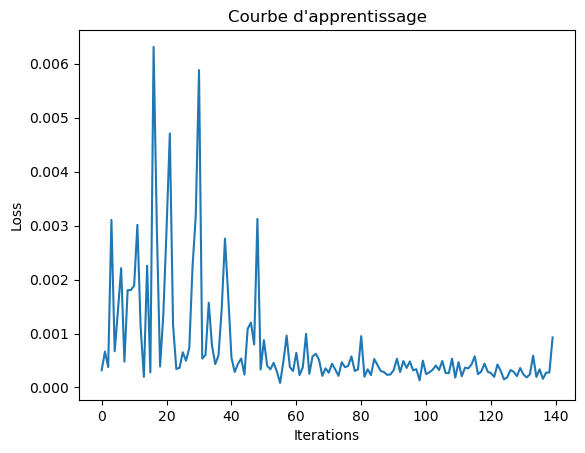

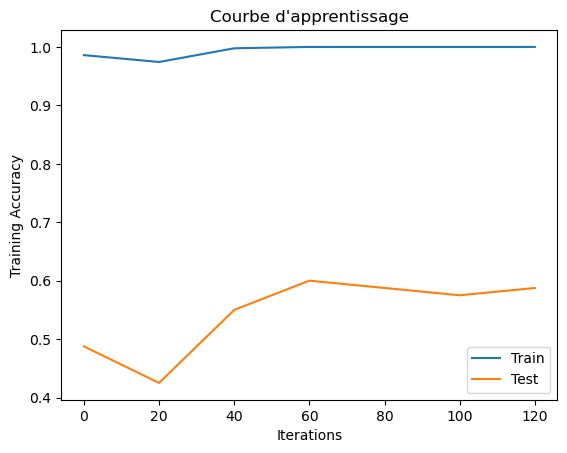

Précision finale Train : 1.0
Précision finale Test : 0.5875


In [36]:
train(modelCNN, num_epochs=10, learning_rate=0.0001, optimizer="adam", batch_size=32)

Essayer d'améliorer le MLP, jouer avec son architecture : changer la fonction d'activation, modifier le nombre de couches, ajouter une normalisation des activations...

Même chose avec le CNN. 

Vous pouvez améliorer les hyperparamètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre pour la tâche donnée ? Pensez-vous avoir une bonne valeur de taux d'apprentissage pour SGD (et pour ADAM) ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

Pour aller plus loin : quelles augmentations pourraient êter pertinentes pour augmenter les spectrogrammes ?

## Amélioration de CNN

In [37]:
import torch.nn.init as init

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.20)
        
        self.fc1 = nn.Linear(128 * 8 * 13, 256)
        self.fc2 = nn.Linear(256, 10)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm1d(256)

        # Initialize weights using Xavier initialization
        self.initialize_weights()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128 * 8 * 13)
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)


In [38]:
cnnbetter = ImprovedCNN()
print(cnnbetter)

ImprovedCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=13312, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track

Epoch 1/12 | Loss: 1.0792: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]
Epoch 2/12 | Loss: 0.7409: 100%|██████████| 14/14 [00:05<00:00,  2.41it/s]
Epoch 3/12 | Loss: 0.7438: 100%|██████████| 14/14 [00:05<00:00,  2.45it/s]
Epoch 4/12 | Loss: 0.6515: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
Epoch 5/12 | Loss: 0.2044: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]
Epoch 6/12 | Loss: 0.3162: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]
Epoch 7/12 | Loss: 0.3684: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]
Epoch 8/12 | Loss: 0.2015: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s]
Epoch 9/12 | Loss: 0.1060: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]
Epoch 10/12 | Loss: 0.2825: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
Epoch 11/12 | Loss: 0.1135: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]
Epoch 12/12 | Loss: 0.1924: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


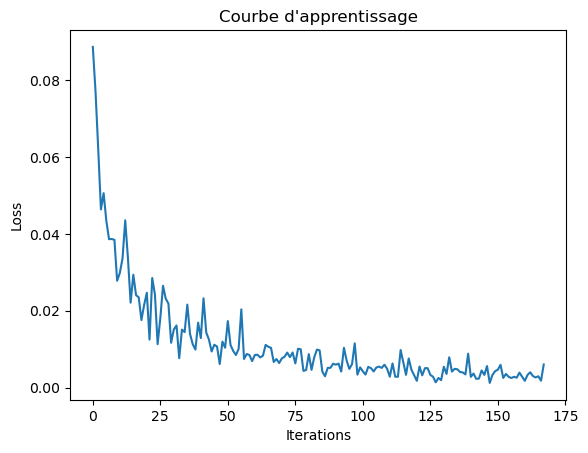

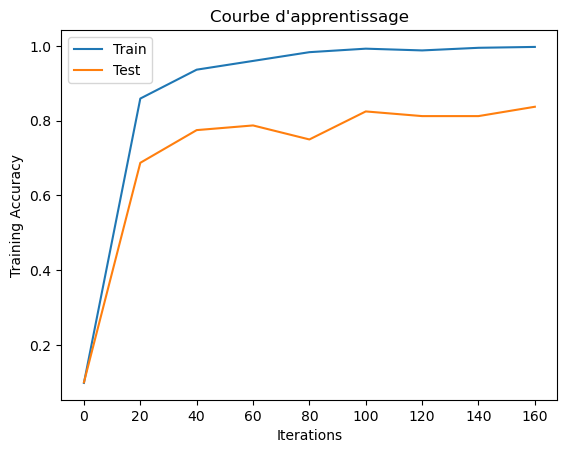

Précision finale Train : 0.9976580796252927
Précision finale Test : 0.8375


In [39]:
train(cnnbetter, num_epochs=12, learning_rate=0.0001, weight_decay=0.001, optimizer="adam", batch_size=32)

## Evalutaion des modeles

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
def get_confusion_matrix(model, data_loader, idx_to_classes):
    model.eval() # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return cm

In [42]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print('Matrice de confusion normalisée') 

    # pour faire la normalisation
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

### MLP amélioré

Matrice de confusion normalisée


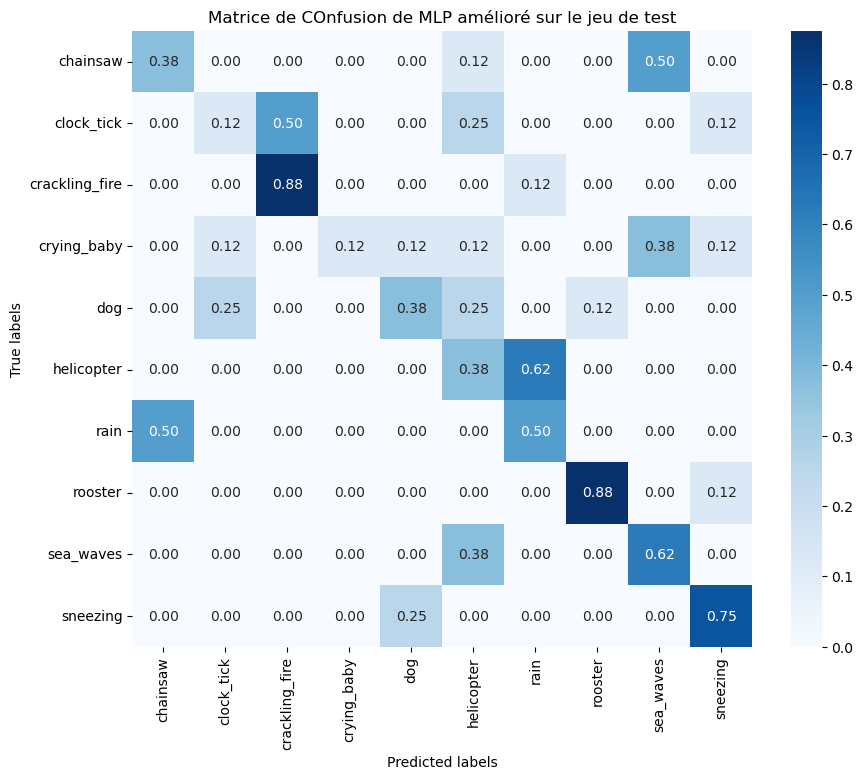

In [43]:

#train_cm = get_confusion_matrix(mlpBetter, train_loader, idx_to_classes)
test_cm = get_confusion_matrix(mlpBetter, test_loader, idx_to_classes)

#plot_confusion_matrix(train_cm, idx_to_classes, title='Training Confusion Matrix')
plot_confusion_matrix(test_cm, idx_to_classes, title='Matrice de COnfusion de MLP amélioré sur le jeu de test')

### CNN amélioré

Matrice de confusion normalisée


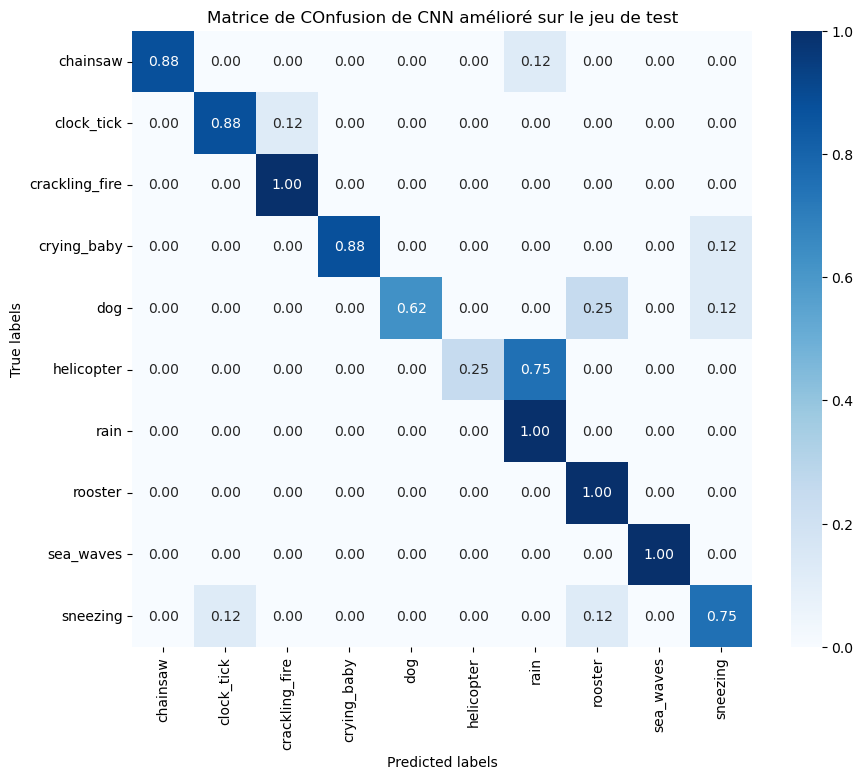

In [44]:
#train_cm = get_confusion_matrix(cnnbetter, train_loader, idx_to_classes)
test_cm = get_confusion_matrix(cnnbetter, test_loader, idx_to_classes)

#plot_confusion_matrix(train_cm, idx_to_classes, title='Training Confusion Matrix')
plot_confusion_matrix(test_cm, idx_to_classes, title='Matrice de COnfusion de CNN amélioré sur le jeu de test')

Pour les 2 modèles les classes 'dog' et 'helicopteur' pose une problème

### Les données mal classée

In [55]:
def show_misclassified_images(model, data_loader, idx_to_classes, num_images=5):
    model.eval()
    misclassified_images = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_images.append((inputs[i], labels[i], preds[i]))
                if len(misclassified_images) >= num_images:
                    break
            if len(misclassified_images) >= num_images:
                break

    # Display misclassified images
    fig, axes = plt.subplots(1, len(misclassified_images), figsize=(15, 3))
    for i, (image, true_label, pred_label) in enumerate(misclassified_images):
        image_np = image.numpy().squeeze() 
        librosa.display.specshow(image_np, cmap='magma', ax=axes[i])
        axes[i].set_title(f'True: {idx_to_classes[true_label]}, Predicted: {idx_to_classes[pred_label]}')
        axes[i].axis('off')

    plt.show()

MLP

In [56]:
show_misclassified_images(mlpBetter, test_loader, idx_to_classes, num_images=3)

NameError: name 'mlpBetter' is not defined

CNN

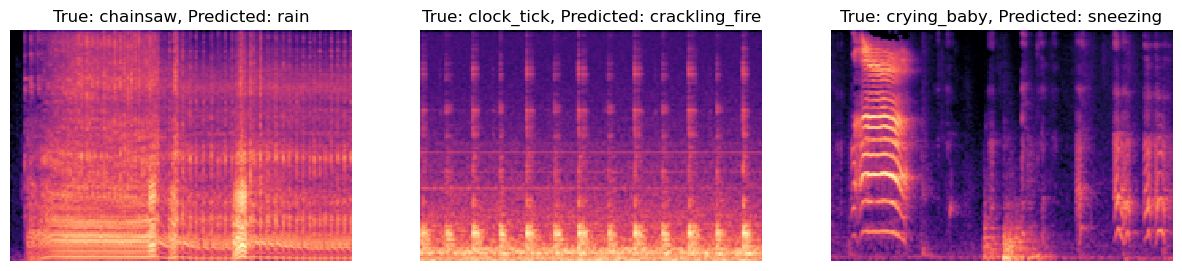

In [84]:
show_misclassified_images(cnnbetter, test_loader, idx_to_classes, num_images=3)